In [1]:
import balltracking.balltrack as blt
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Load FLCT
from pathlib import Path
from IPython import display
import time

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [35]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
outputdir = os.path.join(datadir, 'comparisons/FWHM_11px')

u = 368000 / 60

fwhm = 11
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 14
step = fwhm
fov = np.s_[pad:-pad:step, pad:-pad:step]

nframes = range(30, 365, 5)
tranges = [[0, nt] for nt in range(30, 365, 5)]
print(tranges)
nflows = len(tranges)

[[0, 30], [0, 35], [0, 40], [0, 45], [0, 50], [0, 55], [0, 60], [0, 65], [0, 70], [0, 75], [0, 80], [0, 85], [0, 90], [0, 95], [0, 100], [0, 105], [0, 110], [0, 115], [0, 120], [0, 125], [0, 130], [0, 135], [0, 140], [0, 145], [0, 150], [0, 155], [0, 160], [0, 165], [0, 170], [0, 175], [0, 180], [0, 185], [0, 190], [0, 195], [0, 200], [0, 205], [0, 210], [0, 215], [0, 220], [0, 225], [0, 230], [0, 235], [0, 240], [0, 245], [0, 250], [0, 255], [0, 260], [0, 265], [0, 270], [0, 275], [0, 280], [0, 285], [0, 290], [0, 295], [0, 300], [0, 305], [0, 310], [0, 315], [0, 320], [0, 325], [0, 330], [0, 335], [0, 340], [0, 345], [0, 350], [0, 355], [0, 360]]


In [36]:
# Load Balltrack velocities (processed with balltracking_scripts/generic_balltrack.py)
bvxs = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vx'] for trange in tranges]
bvys = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vy'] for trange in tranges]

In [25]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
vx_stein_l, vy_stein_l = zip(*[load_vel_mean((svx_files, svy_files), trange) for trange in tranges])
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = zip(*[smooth_vel(vx, vy, fwhm, kernel='boxcar') for vx, vy in zip(vx_stein_l, vy_stein_l)])
npts = vx_stein_sm[0][fov].size

### Load FLCT

In [26]:
# Load FLCT
#datadir_flct = os.path.expanduser('~/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma7_flct_v1.06')
datadir_flct = os.path.expanduser('~/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma11')
fvx_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vx*.fits'))))
fvy_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vy*.fits'))))
fcal = 1.44
print('nb of FLCT maps = ', len(fvx_files))

nb of FLCT maps =  363


In [27]:
# Average over time
fvxs, fvys = zip(*[load_vel_mean((fvx_files, fvy_files), trange) for trange in tranges])
fvxs_cal = [fvx * fcal  for fvx in fvxs]
fvys_cal = [fvy * fcal  for fvy in fvxs]

In [37]:
fps, frs, _, _, _ = zip(*[np.polyfit(fvxs[i][fov].ravel()*u, vx_stein_sm[i][fov].ravel(), 1, full=True) for i in range(nflows)])
frs = [np.sqrt(fr[0]/npts) for fr in frs]

fp_cals, fr_cals, _, _, _ = zip(*[np.polyfit(fvxs_cal[i][fov].ravel()*u, vx_stein_sm[i][fov].ravel(), 1, full=True) for i in range(nflows)])
fr_cals = [np.sqrt(fr_cal[0]/npts) for fr_cal in fr_cals]

In [38]:
# Calculate residuals RMSE
u = 368000 / 60
npts = vx_stein_sm[0][fov].size
bps, brs, _, _, _ = zip(*[np.polyfit(bvxs[i][fov].ravel()*u, vx_stein_sm[i][fov].ravel(), 1, full=True) for i in range(nflows)])
brs = [np.sqrt(br[0]/npts) for br in brs]
print('residuals (balltracking - both - calibrated) = ', brs[0])
print('bp[0] = ', bps[0][0])

# bp_top, br_top, _, _, _ = np.polyfit(vx_top[fov].ravel()*u, vx_stein_sm[0][fov].ravel(), 1, full=True)
# br_top = np.sqrt(br_top[0]/npts)
# print('residuals (balltracking - top) = ', br_top)
# print('bp_top[0] = ', bp_top[0])
# print('cal_top = ', cal_top)


bRMSEs = [np.sqrt(np.mean((vx_stein_sm[i][fov] - bvxs[i][fov]*u)**2)) for i in range(nflows)]
print('RMSE Balltracking = ',  bRMSEs[0])

fRMSE_uncals = [np.sqrt(np.mean((vx_stein_sm[i][fov] - fvxs[i][fov]*u)**2)) for i in range(nflows)]
print('RMSE FLCT (uncalibrated) = ',  fRMSE_uncals[0])

fRMSE_cals = [np.sqrt(np.mean((vx_stein_sm[i][fov] - fvxs_cal[i][fov]*u)**2)) for i in range(nflows)]
print('RMSE FLCT (calibrated) = ',  fRMSE_cals[0])

# RMSE_b_bot = np.sqrt(np.mean((vx_stein_sm[0][fov] - vx_bot[fov]*u*cal_bot)**2))
# print('RMSE_b_bot = ',  RMSE_b_bot)

# RMSE_f = np.sqrt(np.mean((vx_stein_sm[0][fov] - vx_flct[fov]*u)**2))
# print('RMSE_f = ', RMSE_f)

residuals (balltracking - both - calibrated) =  170.90434718854684
bp[0] =  0.9913969038550071
RMSE Balltracking =  171.7749420172954
RMSE FLCT (uncalibrated) =  255.58094994051956
RMSE FLCT (calibrated) =  226.07966315585958


In [9]:
# Calculate correlations between Stein and Balltracking
bcorrs = [calc_c_pearson(vx_stein_sm[i], bvxs[i], vy_stein_sm[i], bvys[i], fov=fov) for i in range(len(tranges))]
fcorrs = [calc_c_pearson(vx_stein_sm[i], fvxs[i], vy_stein_sm[i], fvys[i], fov=fov) for i in range(len(tranges))]

/Users/rattie/Data/Ben/SteinSDO/comparisons/FWHM_11px/balltracking_flct_0.png


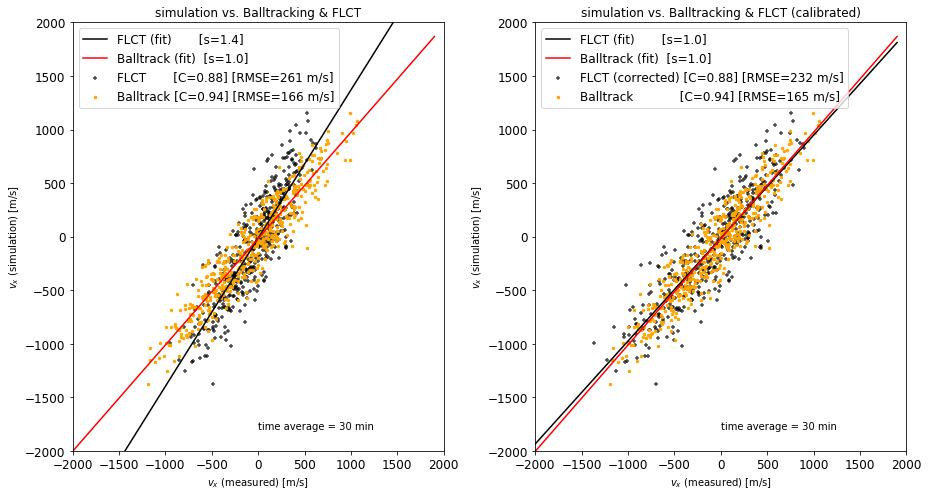

In [16]:
%matplotlib inline

x = np.arange(-2000, 2000, 100)

idx = 0

flct_fit = np.poly1d(fps[idx])(x)
flct_fit_cal = np.poly1d(fp_cals[idx])(x)
b_fit = np.poly1d(bps[idx])(x)


fig, ax = plt.subplots(1,2, figsize = (13,7))
ax[0].scatter(fvxs[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='+', s=20, color='black', alpha=0.7, label = 'FLCT       [C={:1.2f}] [RMSE={:1.0f} m/s]'.format(fcorrs[idx], fRMSE_uncals[idx]))
ax[0].scatter(bvxs[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='o', s=6, color='orange', alpha=1.0, label = 'Balltrack [C={:1.2f}] [RMSE={:1.0f} m/s]'.format(bcorrs[idx], bRMSEs[idx]))

ax[0].plot(x, flct_fit, color='black', label='FLCT (fit)       [s={:1.1f}] '.format(fps[idx][0]))
ax[0].plot(x, b_fit, color='red', label='Balltrack (fit)  [s={:1.1f}] '.format(bps[idx][0]))

ax[0].axis([-2000, 2000, -2000, 2000])
ax[0].set_xlabel(r'$v_x$ (measured) [m/s]')
ax[0].set_ylabel(r'$v_x$ (simulation) [m/s]')
ax[0].legend(prop={'size': 12}, loc='upper left')
ax[0].set_title('simulation vs. Balltracking & FLCT')
ax[0].text(0, -1800, 'time average = {:d} min'.format(tranges[idx][1]))

ax[1].scatter(fvxs_cal[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='+', s=20, color='black', alpha=0.7, label = 'FLCT (corrected) [C={:1.2f}] [RMSE={:1.0f} m/s]'.format(fcorrs[idx], fRMSE_cals[idx]))
ax[1].scatter(bvxs[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='o', s=6, color='orange', alpha=1.0, label =     'Balltrack            [C={:1.2f}] [RMSE={:1.0f} m/s]'.format(bcorrs[idx], brs[idx]))

ax[1].plot(x, flct_fit_cal, color='black', label='FLCT (fit)       [s={:1.1f}] '.format(fp_cals[idx][0]))
ax[1].plot(x, b_fit, color='red', label='Balltrack (fit)  [s={:1.1f}] '.format(bps[idx][0]))


ax[1].axis([-2000, 2000, -2000, 2000])
ax[1].set_xlabel(r'$v_x$ (measured) [m/s]')
ax[1].set_ylabel(r'$v_x$ (simulation) [m/s]')
ax[1].legend(prop={'size': 12}, loc='upper left')
ax[1].set_title('simulation vs. Balltracking & FLCT (calibrated)')
ax[1].text(0, -1800, 'time average = {:d} min'.format(tranges[idx][1]))

plt.tight_layout()
file = os.path.join(outputdir, 'balltracking_flct_{:d}.png'.format(idx))
plt.savefig(file, dpi=300)
#plt.close()
print(file)

In [14]:
file

'/Users/rattie/Data/Ben/SteinSDO/comparisons/FWHM_11px/balltracking_flct_0.png'

In [12]:
for idx in range(0, nflows):
#idx = 0

    flct_fit = np.poly1d(fps[idx])(x)
    flct_fit_cal = np.poly1d(fp_cals[idx])(x)
    b_fit = np.poly1d(bps[idx])(x)


    fig, ax = plt.subplots(1,3, figsize = (15,6))

    ax[0].scatter(fvxs_cal[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='+', s=20, color='black', alpha=0.7, label = 'FLCT (corrected)')
    ax[0].scatter(bvxs[idx][fov].ravel()*u, vx_stein_sm[idx][fov].ravel(), marker='o', s=6, color='orange', alpha=1.0, label =     'Balltrack')

    ax[0].plot(x, flct_fit_cal, color='black', label='FLCT (fit)')
    ax[0].plot(x, b_fit, color='red', label='Balltrack (fit)')


    ax[0].axis([-2000, 2000, -2000, 2000])
    ax[0].set_xlabel(r'$v_x$ (measured) [m/s]')
    ax[0].set_ylabel(r'$v_x$ (simulation) [m/s]')
    ax[0].legend(prop={'size': 12}, loc='upper left')
    ax[0].set_title('Balltracking & FLCT (calibrated)')
    ax[0].text(-800, -1800, 'Time average = {:d} min'.format(tranges[idx][1]))

    ax[1].plot(nframes[idx], bcorrs, color='red', label='Balltracking')
    ax[1].plot(nframes[idx], fcorrs, label='FLCT')
    ax[1].axvline(x=tranges[idx][1], color='black', alpha=0.5)
    ax[1].set_title('Pearson Correlation')
    ax[1].set_xlabel('Time average (min)')
    ax[1].set_ylabel('Correlation')
    ax[1].set_ylim([0.8, 1.0])
    ax[1].grid()
    ax[1].legend(loc='lower right')

    ax[2].plot(nframes[idx]*45/60, bRMSEs, ls='--', color='red', label='Balltracking')
    ax[2].plot(nframes[idx], fRMSE_cals, ls='--', label='FLCT')
    ax[2].axvline(x=tranges[idx][1], color='black', alpha=0.5)
    ax[2].set_title('RMSE')
    ax[2].set_xlabel('Time average (min)')
    ax[2].set_ylabel('RMSE (m/s)')
    ax[2].grid()
    ax[2].legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(outputdir, 'balltracking_flct_3panels_{:d}.png'.format(idx)), dpi=300)
    plt.close()

IndentationError: unexpected indent (<ipython-input-12-33b855c316db>, line 4)

In [ ]:
#%matplotlib notebook

fig, ax = plt.subplots(2,1, figsize = (7,11))
ax[0].plot(nframes, bcorrs, color='orange', label='Balltracking')
ax[0].plot(nframes, fcorrs, label='FLCT')
ax[0].set_title('Correlation at 7-px boxcar average')
ax[0].set_xlabel('time average (min)')
ax[0].set_ylabel('Pearson Correlation')
ax[0].set_ylim([0.8, 1.0])
ax[0].grid()
ax[0].legend()

ax[1].plot(nframes, bRMSEs, color='orange', label='Balltracking')
ax[1].plot(nframes, fRMSE_cals, label='FLCT')
ax[1].set_title('RMSE at 7-px boxcar average')
ax[1].set_xlabel('time average (min)')
ax[1].set_ylabel('RMSE (m/s)')
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'balltracking_flct_correlations.png'), dpi=300)

'/Users/rattie/Data/Ben/SteinSDO/comparisons/FWHM_11px'

range(30, 365, 5)